In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from pzData import pzImg
from ezPzModels import ezPzCNN
import torchvision.models as models
import gc

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("cuda")
else:
    device = torch.device('cpu')
    print("CPU")

gc.collect()
torch.cuda.empty_cache()

cuda


In [3]:
device = torch.device('cpu')

In [4]:
train_labels = "./data/train_labels.csv"
test_labels = "./data/test_labels.csv"
val_labels = "./data/val_labels.csv"
train_dir = test_dir = val_dir = "./data/raw/"

transform = transforms.Compose([
    # transforms.Resize((480, 640)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = pzImg(train_labels, train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

test_dataset = pzImg(test_labels, test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=10)

val_dataset = pzImg(val_labels, val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=10)

In [5]:
# model parameters
input_size = 480*640*3
# for now, this is only a binary classification task
num_classes = 2

In [6]:
def train_cnn(model, batch_size, learning_rate, optim, num_epochs=10):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (x, y) in enumerate(train_loader):
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = criterion(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        train_losses.append(running_loss / len(train_loader))

        model.eval()

        predicted_y = []
        true_y = []
        val_loss = 0
        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_x = val_x.to(device=device, dtype=torch.float32)
                val_y = val_y.to(device=device, dtype=torch.long)
                val_scores = model(val_x)
                _, preds = torch.max(val_scores, 1)
                val_scores = model(val_x)
                val_loss += criterion(val_scores, val_y).item()

                predicted_y.extend(preds.cpu().numpy()) if device != torch.device('cpu') else predicted_y.extend(preds.numpy())
                true_y.extend(val_y.cpu().numpy()) if device != torch.device('cpu') else true_y.extend(val_y.numpy())
            
            val_accuracy = accuracy_score(true_y, predicted_y)
            average_val_loss = val_loss / len(val_loader)
            val_losses.append(average_val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.5f}, Val Acc: {val_accuracy:.2%}")

    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    del model
    del optim
    torch.cuda.empty_cache()
    
    return val_accuracy

Epoch [1/10], Loss: 12.42556, Val Acc: 34.78%
Epoch [2/10], Loss: 8.21278, Val Acc: 65.22%
Epoch [3/10], Loss: 1.72471, Val Acc: 30.43%
Epoch [4/10], Loss: 1.01750, Val Acc: 30.43%
Epoch [5/10], Loss: 0.36763, Val Acc: 52.17%
Epoch [6/10], Loss: 0.19787, Val Acc: 56.52%
Epoch [7/10], Loss: 0.09397, Val Acc: 39.13%
Epoch [8/10], Loss: 0.02907, Val Acc: 52.17%
Epoch [9/10], Loss: 0.00723, Val Acc: 26.09%
Epoch [10/10], Loss: 0.00199, Val Acc: 60.87%


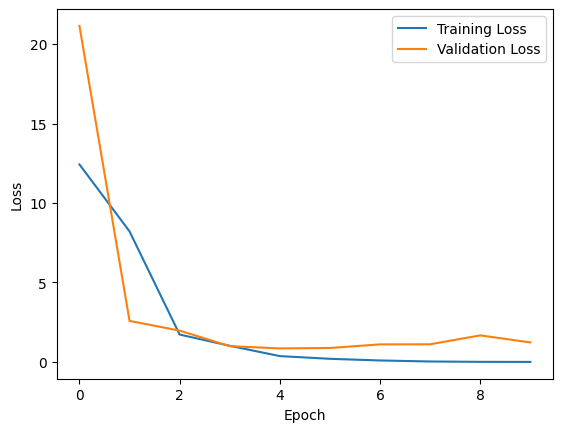

ACCURACY ezPzCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=614400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
), 24, 0.001, <class 'torch.optim.adam.Adam'>:  60.870%
Epoch [1/10], Loss: 0.74998, Val Acc: 65.22%
Epoch [2/10], Loss: 0.10011, Val Acc: 34.78%
Epoch [3/10], Loss: 0.05732, Val Acc: 60.87%
Epoch [4/10], Loss: 0.01517, Val Acc: 60.87%
Epoch [5/10], Loss: 0.00204, Val Acc: 34.78%
Epoch [6/10], Loss: 0.00200, Val Acc: 56.52%
Epoch [7/10], Loss: 0.00008, Val Acc: 47.83%
Epoch [8/10], Loss: 0.00010, Val Acc: 47.83%
Epoch [9/10], Loss: 0.00003, Val Acc: 56.52%
Epoch [10/10], Loss: 0.00001, Val Acc: 43.48%


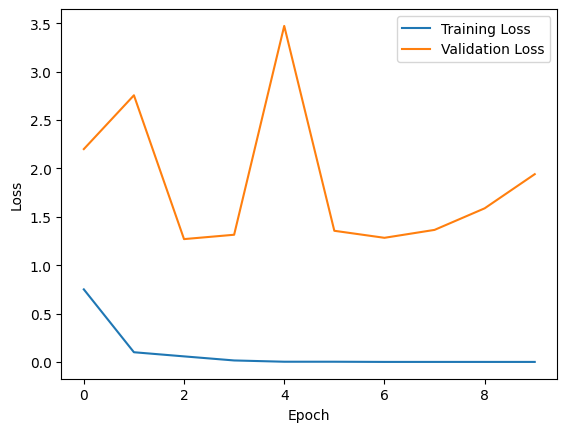

ACCURACY ezPzCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=614400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
), 16, 0.001, <class 'torch.optim.adam.Adam'>:  43.478%
Epoch [1/10], Loss: 0.00000, Val Acc: 56.52%
Epoch [2/10], Loss: 0.29665, Val Acc: 65.22%
Epoch [3/10], Loss: 6.97287, Val Acc: 34.78%
Epoch [4/10], Loss: 0.43061, Val Acc: 26.09%
Epoch [5/10], Loss: 0.00000, Val Acc: 39.13%
Epoch [6/10], Loss: 0.00000, Val Acc: 43.48%
Epoch [7/10], Loss: 0.00000, Val Acc: 52.17%
Epoch [8/10], Loss: 0.00000, Val Acc: 60.87%
Epoch [9/10], Loss: 0.00000, Val Acc: 60.87%
Epoch [10/10], Loss: 0.00000, Val Acc: 60.87%


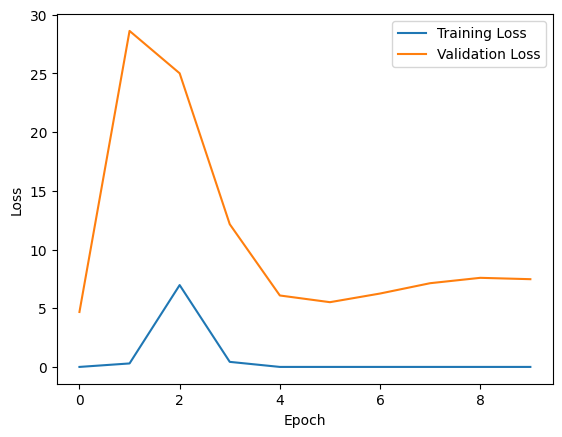

ACCURACY ezPzCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=614400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
), 24, 0.002, <class 'torch.optim.adam.Adam'>:  60.870%
Epoch [1/10], Loss: 0.00000, Val Acc: 47.83%
Epoch [2/10], Loss: 0.00000, Val Acc: 43.48%
Epoch [3/10], Loss: 0.00000, Val Acc: 34.78%
Epoch [4/10], Loss: 0.00000, Val Acc: 34.78%
Epoch [5/10], Loss: 0.00000, Val Acc: 30.43%
Epoch [6/10], Loss: 0.00000, Val Acc: 30.43%
Epoch [7/10], Loss: 0.00000, Val Acc: 30.43%
Epoch [8/10], Loss: 0.00000, Val Acc: 30.43%
Epoch [9/10], Loss: 0.00000, Val Acc: 34.78%
Epoch [10/10], Loss: 0.00000, Val Acc: 34.78%


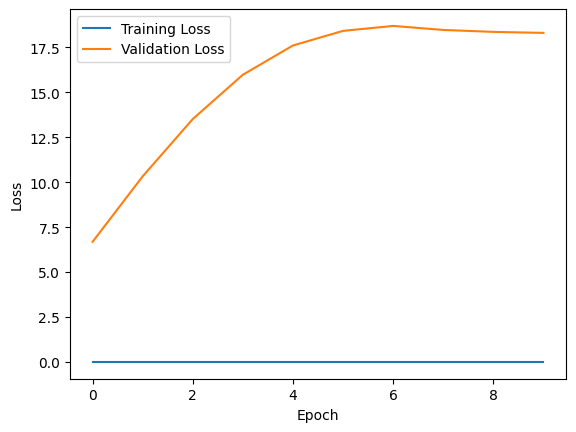

ACCURACY ezPzCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=614400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
), 16, 0.002, <class 'torch.optim.adam.Adam'>:  34.783%
Best Parameters: {'model': ezPzCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=614400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
), 'learning_rate': 0.001, 'batch_size': 24, 'optim': <class 'torch.optim.adam.Adam'>}
Best Accuracy: 0.6086956521739131


In [7]:
num_classes = 2

# resnet = models.resnet50(pretrained=True)
# resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)

param_grid = {
    'model': [ezPzCNN(num_classes)],
    'learning_rate': [0.001, 0.002],#0.0006]
    'batch_size': [24, 16],
    # 'dropout': [0.2, 0.4, 0.6, 0.8],
    'optim': [torch.optim.Adam]#, torch.optim.Adagrad]
}

best_accuracy = 0.0
best_params = {}
for learning_rate in param_grid['learning_rate']:
    for batch_size in param_grid['batch_size']:
        for optim in param_grid['optim']:
            for model in param_grid['model']:
                accuracy = train_cnn(model, batch_size, learning_rate, optim)
                print(f"ACCURACY {model}, {batch_size}, {learning_rate}, {optim}:  {accuracy:.3%}")
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {'model': model, 'learning_rate': learning_rate, 'batch_size': batch_size, 'optim': optim}

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'])

model = best_params['model'].to(device)
criterion = nn.CrossEntropyLoss()
optimizer = best_params['optim'](model.parameters(), lr=best_params['learning_rate'])

train_losses = []
val_losses = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (x, y) in enumerate(train_loader):
        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.long)

        scores = model(x)
        loss = criterion(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    train_losses.append(running_loss / len(train_loader))

    model.eval()

    predicted_y = []
    true_y = []
    val_loss = 0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x = val_x.to(device=device, dtype=torch.float32)
            val_y = val_y.to(device=device, dtype=torch.long)
            val_scores = model(val_x)
            _, preds = torch.max(val_scores, 1)
            val_scores = model(val_x)
            val_loss += criterion(val_scores, val_y).item()

            predicted_y.extend(preds.cpu().numpy()) if device != torch.device('cpu') else predicted_y.extend(preds.numpy())
            true_y.extend(val_y.cpu().numpy()) if device != torch.device('cpu') else true_y.extend(val_y.numpy())
        
        val_accuracy = accuracy_score(true_y, predicted_y)
        average_val_loss = val_loss / len(val_loader)
        val_losses.append(average_val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.5f}, Val Acc: {val_accuracy:.2%}")

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

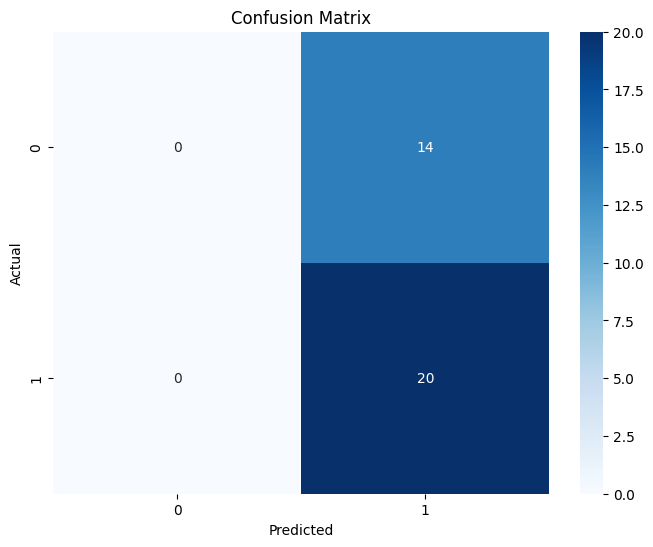

In [12]:
confusion = confusion_matrix(true_y, predicted_y)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
best_model = model

In [36]:
torch.save(best_model, "bin_cnn.pth")